# AnyoneAI - Final Project
> Hospitalization Prediction for Elderly Population

The project aims to predict the probability of hospitalization for elderly Mexican individuals using machine learning algorithms and data such as demographics, health indicators, and medical history. The model can help healthcare providers identify high-risk patients and allocate resources accordingly. This project is similar to what you have implemented in the last few sprints but with a focus on building a model that can use a few features to make accurate predictions.

### Goal:
The main goal of this project is to ask users to complete a form and use the provided information to predict the risk of hospitalization for that person in the next year. For that task, a Machine Learning model must be trained to make that prediction. Keep in mind the dataset we are going to use has thousands of features but, we can't ask users to complete such amount of fields in the form. We suggest you start using some classic models like Decision Trees, Random Forests, or Gradient Boosting, identify the most important features, and try to refine your model input based on that.

### Main Deliverables:
- Exploratory Dataset Analysis (EDA)
- Scripts used for data pre-processing and data preparation
- Training scripts and trained models. Description of how to reproduce results
- Implementation and training of model for hospitalization prediction
- The final model should need less than 50 features to make predictions
- The final model AUC Score must be over 0.9
- Present results and a demo of the model doing predictions in real time using an API
- Everything must be containerized using Docker

### Additional Optional Deliverables:
- Experiment using Transformer models, you can convert the data to a string, experiment using certain subsets of features, and evaluate how good are the predictions with few input variables.
- Make a UI in which users must complete a form to get the prediction for the demo.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os

import matplotlib.pyplot as plt

from src import config, data_utils, data_eda, preprocessing

## 1. Introduction
The dataset comprises multiple files with information about aging, health, and retirement from the Mexican Family of Health and Retirement surveys:
`H_MHAS_c2.sas7bdat`, `H_MHAS_EOL_b.sas7bdat`  and `H_MEX_COG_A2_2016.dta`. <br>
In this section, we will load the data corresponding to the `H_MHAS_c2.sas7bdat` file and perform a manual filtering of all features based on apriori knowledge of the problem to be solved.

### Getting the data

To access the data for this project, you only need to execute the code below. This will download one sas7bdat file inside the `dataset` folder:

- `H_MHAS_c2.sas7bdat`: The MHAS Dataset is public and free of charge for use but you will have to register on their website to get full access. You can see all the available data in the following link: https://www.mhasweb.org/DataProducts/HarmonizedData.aspx. This file consolidates information throughout the survey duration and is linked by user ID.

In [2]:
h_mhas_c2 = data_utils.get_datasets()

In [3]:
print('In our dataset we have', h_mhas_c2.shape[0], 'subjects')
print('In our dataset we have', h_mhas_c2.shape[1], 'features')

In our dataset we have 26839 subjects
In our dataset we have 5241 features


### Data and Features
The dataset `H_MHAS_c2.sas7bdat` has 26839 rows and 5241 features.

All features are divided into the following sections.

- SECTION A: DEMOGRAPHICS, IDENTIFIERS, AND WEIGHTS (251 features)
- SECTION B: HEALTH (1624 features)
- SECTION C: HEALTH CARE UTILIZATION AND INSURANCE  (236 features)
- SECTION D: COGNITION  (706 features)
- SECTION E: FINANCIAL AND HOUSING WEALTH (148 features)
- SECTION F: INCOME (212 features)
- SECTION G: FAMILY STRUCTURE (223 features)
- SECTION H: EMPLOYMENT HISTORY (110 features)
- SECTION I: RETIREMENT (16 features)
- SECTION J: PENSION (54 features)
- SECTION K: PHYSICAL MEASURES (282 features)
- SECTION L: ASSISTANCE AND CAREGIVING (1103 features)
- SECTION M: STRESS (77 features)
- SECTION O: END OF LIFE PLANNING (33 features)
- SECTION Q: PSYCHOSOCIAL (166 features)

<b> SOME IMPORTANT INSIGHTS </b><br>
Data can be obtained at the link: https://www.mhasweb.org/DataProducts/HarmonizedData.aspx. in different formats.
-   `H_MHAS_c2.sas7bdat` (downloaded for our project 470 MB)-> The disk size is larger, but it contains the data already coded and checked against the documentation, which allows easier data analysis.
-   `H_MHAS_c2.sav` (166 MB) and `H_MHAS_c2.dta` (176 MB)-> smaller size but mostly categorical variables, which makes conversion and analysis more difficult.

In [4]:
categorical_vars = h_mhas_c2.select_dtypes(include=['object']).columns
numerical_vars = h_mhas_c2.select_dtypes(include=['float64']).columns

print('We have ' + str(len(categorical_vars)) + ' categorical features in our dataset')
print('We have ' + str(len(numerical_vars)) + ' numerical features in our dataset')
print('We need to check if we can convert the following to numerical: ')
print(categorical_vars)

We have 7 categorical features in our dataset
We have 5234 numerical features in our dataset
We need to check if we can convert the following to numerical: 
Index(['rahhidnp', 'h1hhidc', 'h2hhidc', 'h3hhidc', 'h4hhidc', 'h5hhidc',
       'acthog'],
      dtype='object')


Since 14 features are categorical, we reviewed the data and realized that it is possible to transform all 14 variables to numerical.

In [5]:
# List of column names to convert to numeric type
columns_to_convert = ['rahhidnp', 'h1hhidc', 'h2hhidc', 'h3hhidc', 'h4hhidc', 'h5hhidc', 
                     'acthog', 's5dyear', 's5dmonth', 's3wghtref', 'r3bpsft', 's3bpsft', 
                     's3bpref', 'r3bpref']

# convert each column to numeric type
for col in columns_to_convert:
    h_mhas_c2[col] = pd.to_numeric(h_mhas_c2[col], errors='coerce')

Finally, we verify that the 5241 features have been transformed into numerics.

In [6]:
numerical_int_vars = h_mhas_c2.select_dtypes(include=['int64']).columns
numerical_float_vars = h_mhas_c2.select_dtypes(include=['float64']).columns

print('Now, all ' + str(len(numerical_int_vars)+len(numerical_float_vars)) + ' features are numerical type variables')


Now, all 5241 features are numerical type variables


<b> SOME IMPORTANT INSIGHTS </b>
-   The first character of the majority of variables indicates whether the variable refers to the reference person (“r”), spouse (“s”), or household (“h”).
-   The second character indicates the wave to which the variable pertains: “1”, “2”, “3”, “4”, “5”, or “A”. The “A” indicates “all,”

In [7]:
starts_with_s = sum(col.startswith('s') for col in h_mhas_c2.columns)
starts_with_r = sum(col.startswith('r') for col in h_mhas_c2.columns)
starts_with_h = sum(col.startswith('h') for col in h_mhas_c2.columns)

print(f"Number of columns starting with 's' from spouse: {starts_with_s}")
print(f"Number of columns starting with 'r' from reference: {starts_with_r}")
print(f"Number of columns starting with 'h' from household: {starts_with_h}")

Number of columns starting with 's' from spouse: 2457
Number of columns starting with 'r' from reference: 2398
Number of columns starting with 'h' from household: 354


<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section A - DEMOGRAPHICS, IDENTIFIERS, AND WEIGHTS </center></h3>

This section consists of 26 subsections (245 features) which are shown below:
-  <b> ` Person Specific Identifier ` </b>  
-  <b> ` Household Identifier ` </b>   
-  <b> ` Spouse Identifier ` </b>   
-  <b> ` Wave Status: Response Indicator ` </b>   
-  Wave Status: Interview Status  
-  <b> ` Sample Cohort ` </b>   
-  <b> ` Whether Proxy Interview ` </b>   
-  Number of Household Respondents  
-  Whether Couple Household  
-  <b> ` Household Analysis Weight ` </b>   
-  <b> ` Person-Level Analysis Weight ` </b> 
-  Interview Dates  
-  Birth Date: Month and Year  
-  <b> ` Death Date: Month and Year ` </b>  
-  Age at Interview (Months and Years)  
-  Gender  
-  Education  
-  Education: Categories by ISCED Codes  
-  Education: Harmonized Education  
-  <b> ` Literacy and Numeracy ` </b>   
-  Indigenous Language  
-  Current Marital Status: Current Partnership Status  
-  Current Marital Status: With Partnership  
-  Current Marital Status: Without Partnership  
-  Number of Marriages  
-  Urban or Rural
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [8]:
elimin_A = [
    'Person Specific Identifier', # Person Specific Identifier  (MANDATORY)
    'Household Identifier', # Household Identifier (MANDATORY) 
    'Spouse Identifier', # Spouse Identifier (MANDATORY)   
    'Response Indicator', # Wave Status: Response Indicator (MANDATORY)   
    # 'Interview Status', # Wave Status: Interview Status  
    'Sample Cohort', # Sample Cohort  
    'Whether Proxy Interview', # Whether Proxy Interview  
    # 'Number of Household Respondents', # Number of Household Respondents  
    # 'Whether Couple Household', # Whether Couple Household  
    'Household Analysis Weight', # Household Analysis Weight (MANDATORY)  
    'Person-Level Analysis Weight', # Person-Level Analysis Weight
    # 'Interview Dates', # Interview Dates  
    # 'Birth Date', # Birth Date: Month and Year  
    'Death Date', # Death Date: Month and Year  
    # 'Age at Interview', # Age at Interview (Months and Years)  
    # 'Gender', # Gender  
    # 'Education', # Education  
    # 'Education_Cat', # Education: Categories by ISCED Codes  
    # 'Education_ Harmon', # Education: Harmonized Education  
    'Literacy and Numeracy', # Literacy and Numeracy  
    # 'Indigenous Language', # Indigenous Language  
    # 'Current Partnership Status', # Current Marital Status: Current Partnership Status  
    # 'With Partnership', # Current Marital Status: With Partnership  
    # 'Without Partnership', # Current Marital Status: Without Partnership  
    # 'Number of Marriages', # Number of Marriages  
    # 'Urban or Rural' # Urban or Rural
]

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section B - HEALTH </center></h3>

This section consists of 27 subsections (1624 features) which are shown below:

-  Self-Report of Health  
-  Activities of Daily Living (ADLs): Raw Recodes  
-  Activities of Daily Living (ADLs): Some Difficulty 
-  Instrumental Activities of Daily Living (IADLs): Raw Recodes  
-  Instrumental Activities of Daily Living (IADLs): Some Difficulty  
-  Other Functional Limitations: Raw Recodes  
-  Other Functional Limitations: Some Difficulty  
-  ADL Summary: Sum ADLs Where Respondent Reports Any Difficulty  
-  IADL Summary: Sum IADLs Where Respondent Reports Any Difficulty  
-  Other Summary Indices: Mobility, Large Muscle, Gross, Fine Motor, Total, Upper, Lower Body Mobility, and NAGI Activities 
-  Doctor Diagnosed Health Problems: Ever Have Condition  
-  Doctor Diagnosed Diseases: Whether Receives Treatment or Medication for Disease  
-  Doctor Diagnosed Diseases: Whether Disease Limits Activity  
-  Doctor Diagnosed Diseases: Age of Diagnosis  
-  Vision  
-  Hearing 
-  Falls  
-  Urinary Incontinence  
-  Persistent Health Problems  
-  <b> ` Sleep ` </b>   
-  Pain  
-  <b> ` Menopause ` </b>   
-  BMI  
-  Health Behaviors: Physical Activity or Exercise  
-  Health Behaviors: Drinking  
-  Health Behaviors: Smoking (Cigarettes)  
-  Health Behaviors: Preventive Care  
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [9]:
elimin_B = {
    # 'Self-Report of Health',  # Self-Report of Health  
    # 'ADLs Raw Recodes',  # Activities of Daily Living (ADLs): Raw Recodes  
    # 'ADLs Some Difficulty',  # Activities of Daily Living (ADLs): Some Difficulty 
    # 'IADLs Raw Recodes',  # Instrumental Activities of Daily Living (IADLs): Raw Recodes  
    # 'IADLs Some Difficulty',  # Instrumental Activities of Daily Living (IADLs): Some Difficulty  
    # 'Other Limitations Raw Recodes',  # Other Functional Limitations: Raw Recodes  
    # 'Other Limitations Some Difficulty',  # Other Functional Limitations: Some Difficulty  
    'ADL Summary',  # ADL Summary: Sum ADLs Where Respondent Reports Any Difficulty  
    'IADL Summary',  # IADL Summary: Sum IADLs Where Respondent Reports Any Difficulty  
    # 'Other Summary Indices',  # Other Summary Indices: Mobility, Large Muscle, Gross, Fine Motor, Total, Upper, Lower Body Mobility, and NAGI Activities 
    # 'Doctor Diagnosed Health Problems',  # Doctor Diagnosed Health Problems: Ever Have Condition  
    # 'Treatment or Medication for Disease',  # Doctor Diagnosed Diseases: Whether Receives Treatment or Medication for Disease  
    # 'Whether Disease Limits Activity',  # Doctor Diagnosed Diseases: Whether Disease Limits Activity  
    # 'Age of Diagnosis',  # Doctor Diagnosed Diseases: Age of Diagnosis  
    # 'Vision',  # Vision  
    # 'Hearing',  # Hearing 
    # 'Falls',  # Falls  
    # 'Urinary Incontinence',  # Urinary Incontinence  
    # 'Persistent Health Problems',  # Persistent Health Problems  
    'Sleep',  # Sleep  
    # 'Pain',  # Pain  
    'Menopause',  # Menopause  
    # 'BMI',  # BMI  
    # 'Physical Activity or Exercise',  # Health Behaviors: Physical Activity or Exercise  
    # 'Drinking',  # Health Behaviors: Drinking  
    # 'Smoking (Cigarettes)',  # Health Behaviors: Smoking (Cigarettes)  
    'Preventive Care',  # Health Behaviors: Preventive Care
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section C - HEALTH CARE UTILIZATION AND INSURANCE </center></h3>

This section consists of 8 subsections (236 features) which are shown below:

-  Medical Care Utilization: Hospital  
-  Medical Care Utilization: Doctor  
-  Medical Care Utilization: Other Medical Care Utilization  
-  Medical Expenditures: Out of Pocket and Total  
-  Covered by Federal Government Health Insurance Program  
-  Covered by Private Health Insurance  
-  Covered by Health Insurance from a Current or Previous Employer  
-  Number of Health Insurance Plans 
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [10]:
elimin_C = {
    # 'Medical Care Hospital',  # Medical Care Utilization: Hospital  
    # 'Medical Care Doctor',  # Medical Care Utilization: Doctor  
    # 'Medical Care Other',  # Medical Care Utilization: Other Medical Care Utilization  
    'Medical Expenditures',  # Medical Expenditures: Out of Pocket and Total  
    'Covered by Government',  # Covered by Federal Government Health Insurance Program  
    'Covered by Private',  # Covered by Private Health Insurance  
    'Covered by Employer',  # Covered by Health Insurance from a Current or Previous Employer  
    # 'Number of Health Insurance Plans',  # Number of Health Insurance Plans
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section D: COGNITION </center></h3>

This section consists of 15 subsections (706 features) which are shown below:
 
-  Cognition Testing Conditions 
-  Self-Reported Memory 
-  Immediate Word Recall 
-  Delayed Word Recall 
-  Summary Scores 
-  Picture Drawing 
-  Verbal Fluency 
-  Visual Scanning 
-  Backwards Counting From 20 
-  Date Naming/Orientation 
-  <b> ` Serial 7’s `</b>  
-  Proxy Cognition: JORM IQCODE 
-  Proxy Cognition: Ratings of Memory and Abilities 
-  Proxy Cognition: Cognitive Impairment 
-  Proxy Cognition: Problem Behaviors in Past Week 
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [11]:
elimin_D = {
    # 'Cognition Testing Conditions',  # Cognition Testing Conditions 
    # 'Self-Reported Memory',  # Self-Reported Memory 
    # 'Immediate Word Recall',  # Immediate Word Recall 
    # 'Delayed Word Recall',  # Delayed Word Recall 
    # 'Summary Scores',  # Summary Scores 
    # 'Picture Drawing',  # Picture Drawing 
    # 'Verbal Fluency',  # Verbal Fluency 
    # 'Visual Scanning',  # Visual Scanning 
    # 'Backwards Counting From 20',  # Backwards Counting From 20 
    'Date Naming/Orientation',  # Date Naming/Orientation 
    # 'Serial 7s',  # Serial 7’s -> 'Serial 7s'
    'JORM IQCODE',  # Proxy Cognition: JORM IQCODE 
    # 'Ratings of Memory and Abilities',  # Proxy Cognition: Ratings of Memory and Abilities 
    # 'Cognitive Impairment',  # Proxy Cognition: Cognitive Impairment 
    # 'Problem Behaviors in Past Week',  # Proxy Cognition: Problem Behaviors in Past Week
}  

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section E - FINANCIAL AND HOUSING WEALTH </center></h3>

This section consists of 15 subsections (148 features) which are shown below:

-  <b> ` Inflation Multiplier  ` </b> 
-  <b> ` Net Value of Real Estate (Not Primary Residence)  ` </b>  
-  <b> ` Net Value of Cars  ` </b>  
-  <b> ` Net Value of Businesses  ` </b>  
-  <b> ` Value of Stocks Shares and Bonds  ` </b>  
-  <b> ` Value of Checking Savings Accounts  ` </b>  
-  <b> ` Value of Other Assets  ` </b> 
-  <b> ` Value of Primary Residence  ` </b>  
-  <b> ` Value of All Mortgages (Primary Residence)  ` </b> 
-  <b> ` Net Value of Primary Residence  ` </b> 
-  <b> ` Home ownership  ` </b> 
-  <b> ` Value of Other Debt  ` </b> 
-  <b> ` Value of Loans Lent  ` </b> 
-  <b> ` Net Value of Non-Housing Financial Wealth (Excluding IRAs)  ` </b> 
-  Total Wealth

</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [12]:
elimin_E = {
    'Inflation Multiplier',  # Inflation Multiplier (MANDATORY)
    'Net Value of Real Estate',  # Net Value of Real Estate (Not Primary Residence) 
    'Net Value of Cars',  # Net Value of Cars 
    'Net Value of Businesses',  # Net Value of Businesses 
    'Value of Stocks',  # Value of Stocks Shares and Bonds 
    'Value of Accounts',  # Value of Checking Savings Accounts 
    'Value of Other',  # Value of Other Assets
    'Value of Residence',  # Value of Primary Residence 
    'Value of Mortgages',  # Value of All Mortgages (Primary Residence)
    'Net Value P Residence',  # Net Value of Primary Residence
    'Home ownership',  # Home ownership
    'Value of Other Debt',  # Value of Other Debt
    'Value of Loans Lent',  # Value of Loans Lent
    'Net Value Financial Wealth',  # Net Value of Non-Housing Financial Wealth (Excluding IRAs)
    # 'Total Wealth',  # Total Wealth
}   

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section F - INCOME </center></h3>

This section consists of 10 subsections (212 features) which are shown below:

-  <b> ` Individual Earnings  ` </b> 
-  <b> ` Household Capital Income  ` </b> 
-  <b> ` Individual Income from Private Pension  ` </b> 
-  <b> ` Individual Public Pension Income  ` </b> 
-  <b> ` Individual Other Pensions Income  ` </b> 
-  <b> ` Individual Total Pensions Income  ` </b> 
-  <b> ` Individual Income from Other Government Transfers  ` </b> 
-  <b> ` All Other Income  ` </b> 
-  Total Household Income (respondent & spouse)
-  Total Household Consumption (full household)
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [13]:
elimin_F = {
    'Individual Earnings',  # Individual Earnings
    'Household Income',  # Household Capital Income
    'Income from Private Pension',  # Individual Income from Private Pension
    'Public Pension Income',  # Individual Public Pension Incomes
    'Other Pensions Income',  # Individual Other Pensions Income
    'Total Pensions Income',  # Individual Total Pensions Income
    'Other Government Transfers',  # Individual Income from Other Government Transfers
    'All Other Income',  # All Other Income
    # 'Total Household Income r&s',  # Total Household Income (respondent & spouse)
    # 'Total Household Consumption h',  # Total Household Consumption (full household)
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section G - FAMILY STRUCTURE </center></h3>

This section consists of 19 subsections (223 features) which are shown below:

-  Number of People Living in Household
-  Number of Living Children
-  Number of Deceased Children
-  Number of Children Ever Born
-  Number of Grandchildren
-  Number of Living Siblings
-  Number of Deceased Siblings
-  Number of Living Parents
-  Parental Mortality
-  Parents' Current Age or Age at Death
-  Parents' Education
-  Any Child Co-Resides with Respondent
-  Any Children Living in the Same City
-  Any Weekly Contact with Children
-  Frequent or Weekly Contact with Relatives and Friends
-  Any Weekly Social Activities or Participate in Religious Groups
-  Financial Transfer from Children
-  Financial Transfer to Children
-  Financial Transfer to Parents
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [14]:
elimin_G = {
    # 'N Living in Household',  # Number of People Living in Household
    # 'N Living Children',  # Number of Living Children
    # 'N Deceased Children',  # Number of Deceased Children
    # 'N Children Ever Born',  # Number of Children Ever Born
    # 'N Grandchildren',  # Number of Grandchildren
    # 'N Living Siblings',  # Number of Living Siblings
    # 'N Deceased Siblings',  # Number of Deceased Siblings
    # 'N Living Parents',  # Number of Living Parents
    # 'Parental Mortality',  # Parental Mortality
    # 'Parents Age or Age at Death',  # Parents' Current Age or Age at Death
    # 'Parents Education',  # Parents' Education
    # 'Any Child with Respondent',  # Any Child Co-Resides with Respondent
    # 'Any Children Same City',  # Any Children Living in the Same City
    # 'Any Weekly Contact with Children',  # Any Weekly Contact with Children
    # 'Frequent Contact with Relatives',  # Frequent or Weekly Contact with Relatives and Friends
    'Weekly Social Activities',  # Any Weekly Social Activities or Participate in Religious Groups
    # 'Financial Transfer from Children',  # Financial Transfer from Children
    # 'Financial Transfer to Children',  # Financial Transfer to Children
    # 'Financial Transfer to Parents',  # Financial Transfer to Parents
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section H - EMPLOYMENT HISTORY </center></h3>

This section consists of 12 subsections (110 features) which are shown below:

-  <b> ` Currently Working for Pay ` <b>  
-  <b> ` Whether Self-Employed ` <b>
-  <b> ` Labor Force Status ` <b>
-  <b> ` In the Labor Force ` <b>
-  Unemployment Status
-  <b> ` Retired Employment Status ` <b>
-  <b> ` Hours at Main Job ` <b>
-  <b> ` Main Activity Years of Tenure ` <b>
-  <b> ` Job Allows Move to Less Demanding Work ` <b>
-  <b> ` Occupation Code for Job with Longest Reported Tenure ` <b>
-  Year Last Job Ended
-  Reason Job Ended
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [15]:
elimin_H = {
    'Currently Working for Pay',  # Currently Working for Pay
    'Whether Self-Employed',  # Whether Self-Employed
    'Labor Force Status',  # Labor Force Status
    'In the Labor Force',  # In the Labor Force
    # 'Unemployment Status',  # Unemployment Status
    'Retired Employment Status',  # Retired Employment Status
    'Hours at Main Job',  # Hours at Main Job
    'Main Activity Years of Tenure',  # Main Activity Years of Tenure
    'Job Allows Move',  # Job Allows Move to Less Demanding Work
    'Occupation Code with Longest',  # Occupation Code for Job with Longest Reported Tenure
    # 'Year Last Job Ended',  # Year Last Job Ended
    # 'Reason Job Ended',  # Reason Job Ended
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section I - RETIREMENT </center></h3>

This section consists of 2 subsections (16 features) which are shown below:

-  <b> ` Whether Retired: Retirement year, if says retired ` </b>
-  Whether Retired: Retirement age, if says retired
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [16]:
elimin_I = {
    'Retirement year',  # Whether Retired: Retirement year, if says retired
    # 'Retirement age',  # Whether Retired: Retirement age, if says retired
}


<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section J - PENSION </center></h3>

This section consists of 7 subsections (54 features) which are shown below:

-  <b> ` Whether Receives Public Pension ` </b>
-  <b> ` Whether Receives Private Pension ` </b>
-  <b> ` Whether Receives Other Pension ` </b>
-  <b> ` Age When Started to Receive a Public Pension ` </b>
-  <b> ` Age When Started to Receive a Private Pension ` </b>
-  <b> ` Whether Current Public Pension(s) Can Continue ` </b>
-  <b> ` Whether Current Private Pension Can Continue ` </b>
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [17]:
elimin_J = {
    'Public Pension',  # Whether Receives Public Pension
    'Private Pension',  # Whether Receives Private Pension
    'Other Pension',  # Whether Receives Other Pension
    'Age Public Pension',  # Age When Started to Receive a Public Pension
    'Age Private Pension',  # Age When Started to Receive a Private Pension
    'Public Pension Continuity',  # Whether Current Public Pension(s) Can Continue
    'Private Pension Continuity',  # Whether Current Private Pension Can Continue
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section K - PHYSICAL MEASURES </center></h3>

This section consists of 8 subsections (282 features) which are shown below:
 
-  Height, Weight, Waist and Hip Circumference Measurements
-  Height, Weight, Waist and Hip Circumference Measurements: Reason Didn't Complete
-  <b> ` Sitting Height ` <b>  
-  <b> ` Sitting Height: Reason Didn't Complete ` <b>
-  Balance Test
-  Balance Test: Reason Didn't Complete
-  <b> ` Blood Pressure Measurements ` <b>
-  <b> ` Blood Pressure Measurements: Reason Didn't Complete ` <b>
-  <b> ` Timed Walk Measurements ` <b>
-  <b> ` Timed Walk Measurements: Reason Didn't Complete ` <b>
-  <b> ` Hand Grip Strength Measurements ` <b>
-  <b> ` Hand Grip Strength Measurements: Reason Didn't Complete ` <b>
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [18]:
elimin_K = {
    # 'Waist and Hip Measure',  # Height, Weight, Waist and Hip Circumference Measurements
    # 'Waist and Hip Measure Incomplete',  # Height, Weight, Waist and Hip Circumference Measurements: Reason Didn't Complete
    'Sitting Height',  # Sitting Height
    'Sitting Height Incomplete',  # Sitting Height: Reason Didn't Complete
    # 'Balance Test',  # Balance Test
    # 'Balance Test Incomplete',  # Balance Test: Reason Didn't Complete
    'Blood Pressure Measure',  # Blood Pressure Measurements
    'Blood Pressure Measure Incomplete',  # Blood Pressure Measurements: Reason Didn't Complete
    'Timed Walk Measure',  # Timed Walk Measurements
    'Timed Walk Measure Incomplete',  # Timed Walk Measurements: Reason Didn't Complete
    'Hand Grip Measure',  # Hand Grip Strength Measurements
    'Hand Grip Measure Incomplete',  # Hand Grip Strength Measurements: Reason Didn't Complete
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section L - ASSISTANCE AND CAREGIVING </center></h3>

This section consists of 31 subsections (1103 features) which are shown below:
 
-  ADL Help
-  IADL Help
-  Whether Uses Personal Aids
-  Future ADL Help
-  Activities of Daily Living: Whether Receives Any Care
-  Activities of Daily Living: Whether Receives Any Informal Care
-  Activities of Daily Living: Receives Informal Care from Spouse
-  Activities of Daily Living: Receives Informal Care from Children or Grandchildren
-  Activities of Daily Living: Receives Informal Care from Relatives
-  Activities of Daily Living: Receives Informal Care from Other Individuals
-  Activities of Daily Living: Whether Receives Any Formal Care
-  Activities of Daily Living: Receives Formal Care from Paid Professional
-  Instrumental Activities of Daily Living: Whether Receives Any Care
-  Instrumental Activities of Daily Living: Whether Receives Any Informal Care
-  Instrumental Activities of Daily Living: Receives Informal Care from Spouse
-  Instrumental Activities of Daily Living: Receives Informal Care from Children or Grandchildren
-  Instrumental Activities of Daily Living: Receives Informal Care from Relatives
-  Instrumental Activities of Daily Living: Receives Informal Care from Other Individuals
-  Instrumental Activities of Daily Living: Whether Receives Any Formal Care
-  Instrumental Activities of Daily Living: Receives Formal Care from Paid Professional
-  Activities of Daily Living and Instrumental Activities of Daily Living: Whether Receives Any Care
-  Activities of Daily Living and Instrumental Activities of Daily Living: Whether Receives Any Informal Care
-  Activities of Daily Living and Instrumental Activities of Daily Living: Receives Informal Care from Spouse
-  Activities of Daily Living and Instrumental Activities of Daily Living: Receives Informal Care from Children or Grandchildren
-  Activities of Daily Living and Instrumental Activities of Daily Living: Receives Informal Care from Relatives
-  Activities of Daily Living and Instrumental Activities of Daily Living: Receives Informal Care from Other Individuals
-  Activities of Daily Living and Instrumental Activities of Daily Living: Whether Receives Any Formal Care
-  Activities of Daily Living and Instrumental Activities of Daily Living: Receives Formal Care from Paid Professional
-  Receives Help with Chores from Children or Grandchildren
-  Provides Informal Care to Children or Grandchildren
-  Provides Personal Care to Parents
-  Provides Informal Care for Sick or Disabled Adults
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [19]:
elimin_L = {
    # 'ADL Help',  # ADL Help
    # 'IADL Help',  # IADL Help
    # 'Personal Aids',  # Whether Uses Personal Aids
    # 'Future ADL Help',  # Future ADL Help
    # 'ADL Any Care',  # Activities of Daily Living: Whether Receives Any Care
    # 'ADL Informal Care',  # Activities of Daily Living: Whether Receives Any Informal Care
    # 'ADL Informal Care Spouse',  # Activities of Daily Living: Receives Informal Care from Spouse
    # 'ADL Care Children or Grandchildren',  # Activities of Daily Living: Receives Informal Care from Children or Grandchildren
    # 'ADL Care Relatives',  # Activities of Daily Living: Receives Informal Care from Relatives
    # 'ADL Care Other Individuals',  # Activities of Daily Living: Receives Informal Care from Other Individuals
    # 'ADL Formal Care',  # Activities of Daily Living: Whether Receives Any Formal Care
    # 'ADL Care Paid Professional',  # Activities of Daily Living: Receives Formal Care from Paid Professional
    # 'IADL Any Care',  # Instrumental Activities of Daily Living: Whether Receives Any Care
    # 'IADL Informal Care',  # Instrumental Activities of Daily Living: Whether Receives Any Informal Care
    # 'IADL Informal Care Spouse',  # Instrumental Activities of Daily Living: Receives Informal Care from Spouse
    # 'IADL Care Children or Grandchildren',  # Instrumental Activities of Daily Living: Receives Informal Care from Children or Grandchildren
    # 'IADL Care Relatives',  # Instrumental Activities of Daily Living: Receives Informal Care from Relatives
    # 'IADL Care Other Individuals',  # Instrumental Activities of Daily Living: Receives Informal Care from Other Individuals
    # 'IADL Formal Care',  # Instrumental Activities of Daily Living: Whether Receives Any Formal Care
    # 'IADL Care Paid Professional',  # Instrumental Activities of Daily Living: Receives Formal Care from Paid Professional
    # 'ADL & IADL Any Care',  # Activities of Daily Living and Instrumental Activities of Daily Living: Whether Receives Any Care
    # 'ADL & IADL Informal Care',  # Activities of Daily Living and Instrumental Activities of Daily Living: Whether Receives Any Informal Care
    # 'ADL & IADL Care Spouse',  # Activities of Daily Living and Instrumental Activities of Daily Living: Receives Informal Care from Spouse
    # 'ADL & IADL Care Children or Grandchildren',  # Activities of Daily Living and Instrumental Activities of Daily Living: Receives Informal Care from Children or Grandchildren
    # 'ADL & IADL Care Relatives',  # Activities of Daily Living and Instrumental Activities of Daily Living: Receives Informal Care from Relatives
    # 'ADL & IADL Care Other Individuals',  # Activities of Daily Living and Instrumental Activities of Daily Living: Receives Informal Care from Other Individuals
    # 'ADL & IADL Formal Care',  # Activities of Daily Living and Instrumental Activities of Daily Living: Whether Receives Any Formal Care
    # 'ADL & IADL Care Paid Professional',  # Activities of Daily Living and Instrumental Activities of Daily Living: Receives Formal Care from Paid Professional
    # 'Help Children or Grandchildren',  # Receives Help with Chores from Children or Grandchildren
    # 'Provides Care to Children or Grandchildren',  # Provides Informal Care to Children or Grandchildren
    # 'Provides Care to Parents',  # Provides Personal Care to Parents
    # 'Provides Care for Sick or Disabled Adults',  # Provides Informal Care for Sick or Disabled Adults
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section M - STRESS </center></h3>

This section consists of 4 subsections (77 features) which are shown below:
  
-  Social Support: Spouse
-  Social Support: Children
-  Social Support: Friends
-  Experienced Death of a Child
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [20]:
elimin_M = {
    # 'Support Spouse',  # Social Support: Spouse
    # 'Support Children',  # Social Support: Children
    # 'Support: Friends',  # Social Support: Friends
    # 'Experienced Death of a Child',  # Experienced Death of a Child
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section O - END OF LIFE PLANNING </center></h3>

This section consists of 3 subsections (33 features) which are shown below:

-  <b> ` Will: Whether Has a Will ` </b>
-  <b> ` Will: Beneficiaries of Will ` </b>
-  <b> ` Covered by Life Insurance ` </b>
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [21]:
elimin_O = {
    'Has a Will',  # Will: Whether Has a Will
    'Beneficiaries Will',  # Will: Beneficiaries of Will
    'Covered Life Insurance',  # Covered by Life Insurance
}

<span style="font-size:0.8em;">

<h3><center> FEATURE PRESELECTION Section Q - PSYCHOSOCIAL </center></h3>

This section consists of 8 subsections (166 features) which are shown below:

-  Depressive Symptoms: CESD
-  Satisfaction with Life Scale
-  Single Life Satisfaction Question
-  <b> ` Cantril Ladder ` </b> 
</span>

After a subjective discussion with the working group, it was determined that for the `Hospitalization Prediction for Elderly Population` project, we would not need the subsections highlighted in bold. Please refer to the [Feature Screening Document](https://docs.google.com/spreadsheets/d/1TuoJQKG6A5o5RMeKnKRhnNkAR5euQJ8z/edit?usp=sharing&ouid=108194837271105476000&rtpof=true&sd=true) for more information on this decision.

In [22]:
elimin_Q = {
    # 'Depressive Symptoms',  # Depressive Symptoms: CESD
    # 'Satisfaction Life',  # Satisfaction with Life Scale
    # 'Single Life Satisfaction',  # Single Life Satisfaction Question
    'Cantril Ladder',  # Cantril Ladder
}

### Loading of relevant features
Now that we know which characteristics are the most important for our project, we generate a data frame only with the columns of interest; in the same way, we will unify all the waves of different data in one, considering that they are various interviews. Therefore, they can be handled as other subjects.

In [23]:
elimins = [elimin_A, elimin_B, elimin_C, elimin_D, elimin_E, elimin_F, elimin_G, elimin_H, elimin_I, elimin_J, elimin_K, elimin_L, elimin_M, elimin_O, elimin_Q]

app_train = data_utils.outline_dataframe(h_mhas_c2,elimins)
print('In our new dataset we have',app_train.shape[0],'people')
print('In our new dataset we have',app_train.shape[1],'features')


In our new dataset we have 134195 people
In our new dataset we have 847 features


Now, we can check the number of features that belong to each family member (spouse, reference, or household).

In [24]:
starts_with_s = sum(col.startswith('s') for col in app_train.columns)
starts_with_r = sum(col.startswith('r') for col in app_train.columns)
starts_with_h = sum(col.startswith('h') for col in app_train.columns)

print(f"Number of columns starting with 's' from spouse: {starts_with_s}")
print(f"Number of columns starting with 'r' from reference: {starts_with_r}")
print(f"Number of columns starting with 'h' from household: {starts_with_h}")

Number of columns starting with 's' from spouse: 407
Number of columns starting with 'r' from reference: 407
Number of columns starting with 'h' from household: 33


Since the spouse features are equal to reference features, we can separate these two persons, enabling us to have more subjects for our data frame.

In [25]:
app_train = data_utils.unify_spousandref(app_train)
app_train.shape

(124363, 440)

Finally, we save the dataset in a .csv file to have it available and not have to perform this procedure every time we open the notebook.

In [26]:
app_train.to_csv(config.DATASET_TRAIN, index=False)

## 2. Exploratory Data Analysis EDA
In this stage, we will perform the exploratory data analysis (EDA) on our data frame. For this, we will include some of the essential techniques that will allow us not only to understand the structure of the data and summarize its main characteristics but also to give us a better understanding of the training model we will apply in the preprocessing.

### <b> WARNING: </b>
The following code has been created to avoid having to perform part 1 of this notebook. Therefore, you are suggested to load only the libraries before running it to load the debugged data frame.

In [27]:
# Run the following code only if you want to start from here.
app_train = data_utils.get_datatrain()

### TARGET VARIABLE:

As the first part of the EDA, we will analyze the target variable.

Target Variable Distribution:
TARGET
0.0    109722
1.0     14641
Name: count, dtype: int64

Percentage of Each Value:
TARGET
0.0    88.2
1.0    11.8
Name: count, dtype: float64


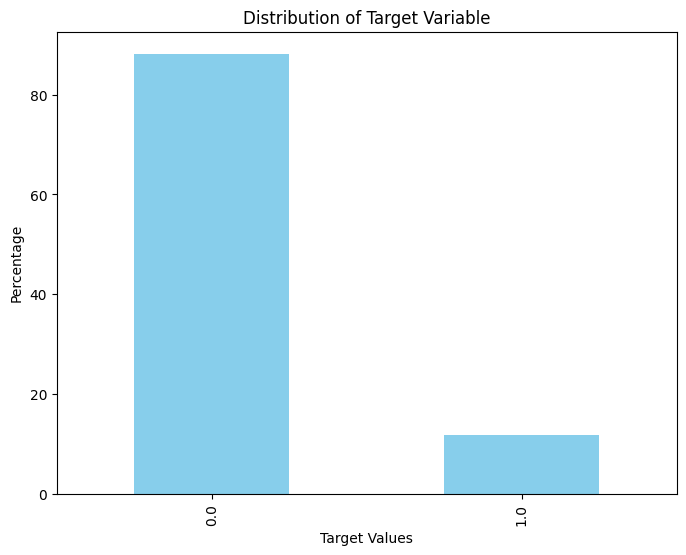

In [29]:
target_distribution = app_train.TARGET.value_counts()

# Print total value count and percentage of each value
print("Target Variable Distribution:")
print(target_distribution)
print("\nPercentage of Each Value:")
print(round(target_distribution/app_train.shape[0] * 100, 1))

# Plot the distribution
plt.figure(figsize=(8, 6))
(target_distribution/app_train.shape[0] * 100).plot(kind='bar', color='skyblue')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Values')
plt.ylabel('Percentage')
plt.show()

As expected, the target variable is quite unbalanced.

## Date Values

Include birth month, year and day into a unique birth date column.


In [30]:
# Convert 'rabyear' and 'rabmonth' to float first, round them, then convert to int, and ultimately to string
app_train['rabyear'] = app_train['rabyear'].astype(float).round(0).fillna(0).astype(int).astype(str)
app_train['rabmonth'] = app_train['rabmonth'].astype(float).round(0).fillna(0).astype(int).astype(str)

# If 'rabmonth' is a single digit, pad with a 0 in front. This ensures the proper format.
app_train['rabmonth'] = app_train['rabmonth'].str.pad(width=2, fillchar='0')

# Combine 'rabyear' and 'rabmonth' to form 'birth_date' 
app_train['birth_date'] = pd.to_datetime(app_train['rabyear'] + app_train['rabmonth'], format='%Y%m', errors='coerce')

# Remove 'rabyear' and 'rabmonth' columns
app_train.drop(columns=['rabyear', 'rabmonth'], inplace=True)

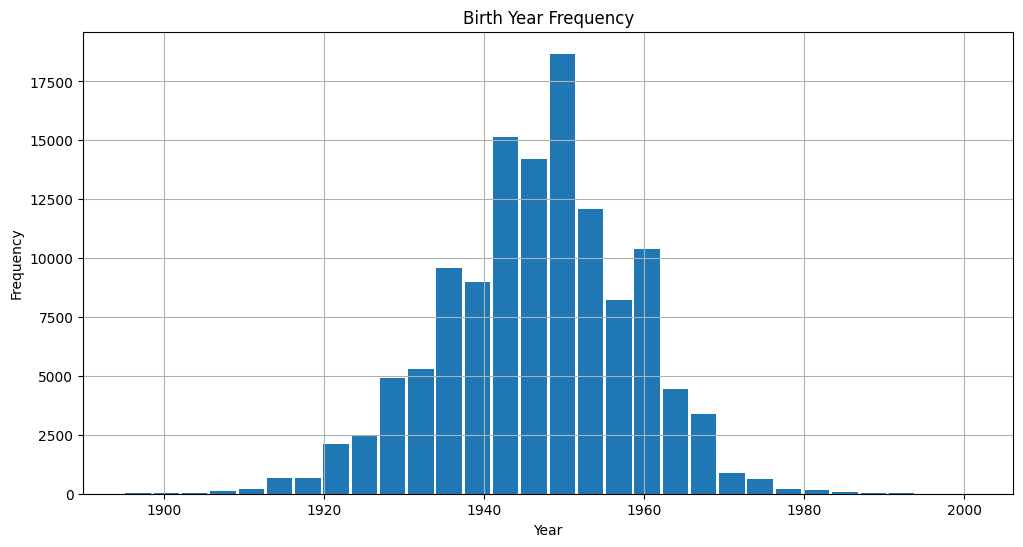

In [33]:
# Ensure the DataFrame is sorted by date
df = app_train.sort_values("birth_date")

# Extract just the year from birth_date, we use dt.year to access the year component of the date
df['birth_year'] = df['birth_date'].dt.year

# Plot a histogram using the new 'birth_year' column
plt.figure(figsize=(12,6))
df['birth_year'].hist(rwidth=0.9, bins=30)
plt.title('Birth Year Frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

In [34]:
# Convert 'rabyear' and 'rabmonth' to float first, round them, then convert to int, and ultimately to string
app_train['rXiwy'] = app_train['rXiwy'].astype(float).round(0).fillna(0).astype(int).astype(str)
app_train['rXiwm'] = app_train['rXiwm'].astype(float).round(0).fillna(0).astype(int).astype(str)

# If 'rabmonth' is a single digit, pad with a 0 in front. This ensures the proper format.
app_train['rXiwm'] = app_train['rXiwm'].str.pad(width=2, fillchar='0')

# Combine 'rabyear' and 'rabmonth' to form 'birth_date' 
app_train['interview_date'] = pd.to_datetime(app_train['rXiwy'] + app_train['rXiwm'], format='%Y%m', errors='coerce')

# Remove 'rabyear' and 'rabmonth' columns
app_train.drop(columns=['rXiwy', 'rXiwm'], inplace=True)

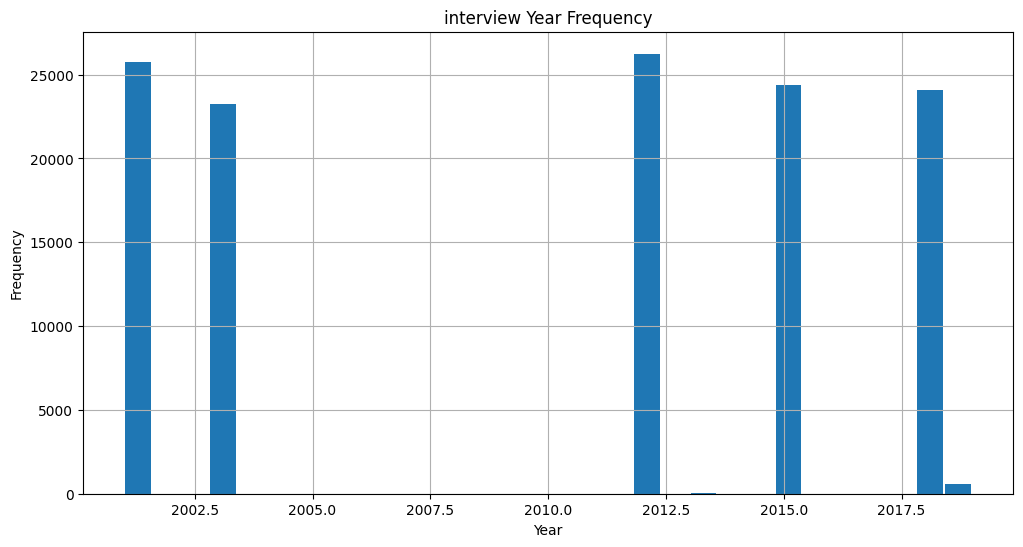

In [35]:
# Ensure the DataFrame is sorted by date
df = app_train.sort_values("interview_date")

# Extract just the year from birth_date, we use dt.year to access the year component of the date
df['interview_year'] = df['interview_date'].dt.year

# Plot a histogram using the new 'birth_year' column
plt.figure(figsize=(12,6))
df['interview_year'].hist(rwidth=0.9, bins=30)
plt.title('interview Year Frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

In [36]:
app_train["interview_date"] = app_train["interview_date"].values.astype(float)
app_train["birth_date"] = app_train["birth_date"].values.astype(float)

# Columns whose values are intended to estimate missing or imputed values are eliminated.
cols_to_drop = ['hXiftot', 'rXgenderf', 'rXiwf', 'rXmpart', 'rXcagem', 'rXfineam', 'rXfbwc20_m', 'rXfddraw2', 'rXfddraw1', 'rXfdlrc8', 'rXfser7', 'hXaftotb', 'hXcftot1m', 'hXfcflag', 'hXtcflag', 'rXtpflag', 'hXhhres', 'rXiwstat', 'rXlgmusa', 'rXlgmusam', 'rXgrossa', 'rXgrossam', 'rXfinea', 'rXuppermob', 'rXlowermob', 'rXfimrc8', 'rXfidraw2', 'rXfidraw1', 'rXrscaredpmm', 'rXrscarehrm', 'rXssupport4m_m', 'rXfsupport4m_m', 'rXksupport4m_m', 'rXcesdm_m', 'rXlsatsc3m', 'rXfvscan', 'rXftr16', 'rXfverbf']
app_train = app_train.drop(cols_to_drop, axis=1)

### Dealing With Null Values
A critical approach we can adopt at this stage is the search for null values. However, we indeed have many characteristics to analyze, and several of them could contain a high percentage of null data, which is counterproductive for the analysis and subsequent training of our model.

In [37]:
# Calculate the percentage of missing data for each column
total_values = app_train.isnull().sum()

missing_percentage = round((total_values / len(app_train)) * 100,1)

# Create a DataFrame to store the results
missing_data_df = pd.DataFrame({
    'Total': total_values,
    'Missing Percentage': missing_percentage
})

# Sort the DataFrame by missing percentage in descending order
missing_data_df = missing_data_df.sort_values(by='Missing Percentage', ascending=False)

# Display the top 20 columns with higher missing percentage
top_missing_columns = missing_data_df.head(25)
print("Top 20 columns with higher missing percentage:")
print(top_missing_columns)

Top 20 columns with higher missing percentage:
              Total  Missing Percentage
rXwghtref    123683                99.5
rXhghtsft    123618                99.4
rXwsttryu    123610                99.4
rXwstsft     123610                99.4
rXwstref     123610                99.4
rXwghttryu   123644                99.4
rXhghtref    123618                99.4
rXhghttryu   123618                99.4
rXhipref     123609                99.4
rXhipsft     123609                99.4
rXhiptryu    123609                99.4
rXwghtsft    123644                99.4
rXstroklmt   122252                98.3
rXbalsft     122186                98.2
rXbaltryu    122186                98.2
rXbalref     122186                98.2
rXmoneyhlp   121513                97.7
rXeathlp     121006                97.3
rXmedhlp     120970                97.3
rXreccancr   120646                97.0
rXhrtatlmt   120505                96.9
rXrecstrok   120289                96.7
rXretage     118986              

As we can see, some of the characteristics contain a percentage higher than `90%`, so we eliminated those columns with a rate of null values higher than `90%`.

In [38]:
var_high_null_percentage = missing_data_df[missing_data_df['Missing Percentage']>90].index.tolist()
print('Are going to be eliminated ' + str(len(var_high_null_percentage)) + ' columns with a percentage of null values higher than 90%')

app_train.drop(columns=var_high_null_percentage,inplace=True)
app_train.shape

Are going to be eliminated 121 columns with a percentage of null values higher than 90%


(124363, 279)

### Correlational Analysis
Another important analysis we can perform is to verify which variables are highly correlated to eliminate possible repeated variables that add to the processing and training lags.</br>
As an example, we will illustrate the process of elimination of features by correlation; for this, we will take the features corresponding to section A, subsection 'Person Specific Identifier'.

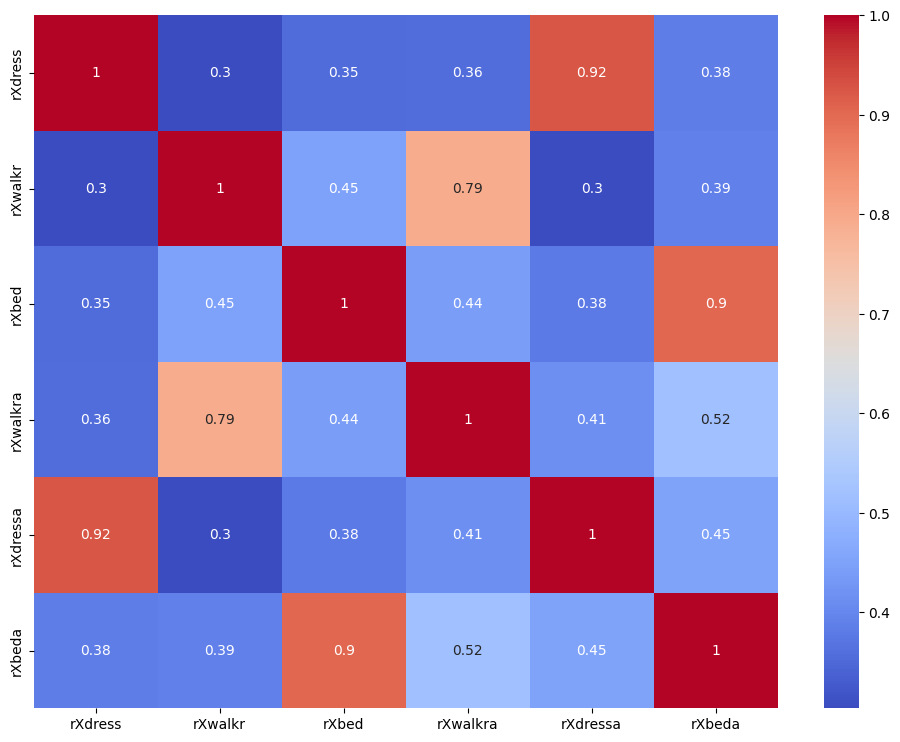

In [39]:
# Person Specific Identifier
# Self-Report of Health
Health2 =['rXdress', 'rXwalkr', 'rXbed', 'rXwalkra', 'rXdressa', 'rXbeda']

# Assume df is your DataFrame
correlation_matrix = app_train[Health2].corr(numeric_only=True)

plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

As we can see, some features have a high correlation, so our next step is to identify these variables and then eliminate them.

In [40]:
# Set correlation threshold
corr_threshold = 0.9

# Drop the features _unified
corr = app_train[Health2].corr(numeric_only=True).abs()
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_)) 
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > corr_threshold)]
print(to_drop)

['rXdressa', 'rXbeda']


Since many features are distributed in 15 sections, we have developed an `elim_bycorr()` function to automate the process.

In [41]:
app_train_dropped = data_eda.elim_bycorr(app_train, 0.9)
dropped_var_correlation = app_train.shape[1] - app_train_dropped.shape[1]
print('We have eliminated ' + str(dropped_var_correlation) + ' highly correlated variables.')
app_train_dropped.shape

We have eliminated 52 highly correlated variables.


(124363, 227)

Finally, we verify that we do not have features that are highly correlated with the target variable.

In [42]:
df = data_eda.remove_highly_correlated(app_train_dropped, 'TARGET', 0.9)
df.shape

(124363, 227)

In [43]:
app_train_dropped.columns.tolist()
Important_Columns = [item[2:] for item in app_train_dropped.columns.tolist()]
Important_Columns, app_train_dropped.columns.tolist()

(['atotb',
  'chdeathe',
  'child',
  'coresd',
  'cpl',
  'ctot1m',
  'dau',
  'dchild',
  'fcamt',
  'fcany',
  'gapcare',
  'gapcarehr',
  'gccare_m',
  'gccarehr_m',
  'grchild',
  'itot',
  'kcnt',
  'lvnear',
  'rcchore',
  'rcchorehr',
  'rcchorenf',
  'rural',
  'son',
  'tcamt',
  'tcany',
  'agey',
  'arms',
  'arthlmt',
  'arthre',
  'bath',
  'batha',
  'bed',
  'bede',
  'binged',
  'bmi',
  'breath_m',
  'bwc20',
  'cage',
  'cancre',
  'cesd_m',
  'chair',
  'clim1',
  'clims',
  'cncrchem',
  'cncrmeds',
  'cncrothr',
  'cncrradn',
  'cncrsurg',
  'dadage',
  'dadliv',
  'ddraw1',
  'ddraw2',
  'decsib',
  'dentim1y',
  'dentst1y',
  'depres',
  'diabe',
  'dime',
  'dlrc8',
  'doctim1y',
  'doctor1y',
  'dress',
  'drink',
  'drinkb',
  'drinkbd',
  'drinkcr',
  'drinkcut',
  'drinkd',
  'drinkn',
  'drinknr',
  'eat',
  'eata',
  'effort',
  'energ',
  'enlife',
  'fall',
  'fallnum',
  'fatigue',
  'fineaa',
  'fletdow_m',
  'flone',
  'fopenup_m',
  'frely_m',
  'fs

In [46]:
df_temp = pd.read_excel('./Feature Screening Document.xlsx', 'Sheet1', skiprows=1)
df_temp = df_temp[df_temp['Note'] == "{0: 'NO', 1: 'YES'}"]
df_temp = df_temp['Feature with Color'].str.replace("'", "").str.strip().tolist()

df_temp

['hXcpl',
 'raindlang',
 'rXwalkra',
 'rXbatha',
 'rXeata',
 'rXtoilta',
 'rXarthlmt',
 'rXhibpe',
 'rXdiabe',
 'rXcancre',
 'rXrespe',
 'rXhrtatte',
 'rXhearte',
 'rXstroke',
 'rXarthre',
 'rXdrink',
 'rXdrinkb',
 'rXdrinkcut',
 'rXdrinkcr',
 'rXdrinkbd',
 'rXdrinknr',
 'rXcholst',
 'rXflusht',
 'rXbreast',
 'rXmammog',
 'rXpapsm',
 'rXprost',
 'rXrxhibp',
 'rXrxdiabi',
 'rXrxdiab',
 'rXcncrchem',
 'rXcncrsurg',
 'rXcncrradn',
 'rXcncrmeds',
 'rXcncrothr',
 'rXrxresp',
 'rXrxhrtat',
 'rXrxstrok',
 'rXrxarthr',
 'rXswell',
 'rXbreath_m',
 'rXwheeze',
 'rXfatigue',
 'rXglasses',
 'rXhearaid',
 'rXfall',
 'rXhip50e',
 'rXhip_m',
 'rXhip',
 'rXlgmusaa',
 'rXuppermoba',
 'rXlowermoba',
 'rXurina2y',
 'rXurinurg2y',
 'rXurincgh2y',
 'rXpainfr',
 'rXpaina',
 'rXsmokev',
 'rXsmoken',
 'rXdoctor1y',
 'rXcovr_m',
 'rXcovs_m',
 'rXoutpt1y',
 'rXdentst1y',
 'rXhigov',
 'rXhipriv',
 'rXnovisual',
 'rXnopencil',
 'hXcoresd',
 'hXfcany',
 'hXkcnt',
 'hXlvnear',
 'hXtcany',
 'rXmomliv',
 'rXdadliv',


In [81]:
filtering_features_df = app_train_dropped[
    [temp_col for temp_col in df_temp if temp_col in app_train_dropped.columns]]

percentages = [filtering_features_df[x].value_counts(dropna = False) / filtering_features_df.shape[0]
               for x in filtering_features_df.columns]

percentages_15_85 = [percentage for percentage in percentages
                     if percentage.min() >= 0.15 and percentage.max() <= 0.85]

percentages_15_85

[rXpaina
 NaN    0.638759
 0.0    0.189687
 1.0    0.171554
 Name: count, dtype: float64,
 rXrfcnt
 NaN    0.438868
 1.0    0.366652
 0.0    0.194479
 Name: count, dtype: float64,
 rXftrhlp
 NaN    0.444312
 1.0    0.347121
 0.0    0.208567
 Name: count, dtype: float64]

## 3. Preprocessing


In [98]:
df = preprocessing.preprocess_dataframe(df)
working_train_df = df.drop(columns="TARGET", axis=1)
y_df = df["TARGET"]

In [99]:
X_df = pd.get_dummies(
    df, dummy_na=True, drop_first=True)
# Fill missing values using interpolation
X_df = X_df.interpolate()
X_df

,hXatotb,hXchild,hXctot1m,hXdau,hXdchild,hXfcamt,hXgapcarehr,hXgccarehr_m,hXgrchild,hXitot,...,rXwheeze_YES,rXwheeze_nan,rafeduc_m_No education,rafeduc_m_Primary,rafeduc_m_Some primary,rafeduc_m_nan,rameduc_m_No education,rameduc_m_Primary,rameduc_m_Some primary,rameduc_m_nan
0,3.065758e+05,5.0,740.0,0.0,1.0,0.0,0.0,0.0,9.0,16800.000000,...,True,False,True,False,False,False,True,False,False,False
1,3.065758e+05,5.0,740.0,0.0,1.0,0.0,0.0,0.0,9.0,16800.000000,...,False,False,True,False,False,False,True,False,False,False
2,8.350000e+04,6.0,500.0,3.0,2.0,9600.0,0.0,2920.0,6.0,31200.000000,...,True,False,False,False,True,False,True,False,False,False
3,8.350000e+04,6.0,500.0,3.0,2.0,9600.0,0.0,2920.0,6.0,31200.000000,...,False,False,True,False,False,False,True,False,False,False
4,1.316690e+05,4.0,2000.0,2.0,0.0,24000.0,0.0,730.0,1.0,96000.000000,...,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124358,1.220000e+06,2.0,17000.0,1.0,0.0,0.0,0.0,2190.0,0.0,330000.000000,...,False,True,False,False,True,False,False,False,True,False
124359,2.082212e+06,9.0,2500.0,5.0,0.0,0.0,0.0,104.0,20.0,127000.000000,...,False,True,True,False,False,False,True,False,False,False
124360,2.082212e+06,9.0,2500.0,5.0,0.0,0.0,0.0,104.0,20.0,127000.000000,...,False,True,True,False,False,False,True,False,False,False
124361,3.521420e+06,2.0,16000.0,1.0,0.0,0.0,0.0,730.0,5.0,147155.015625,...,False,True,False,False,True,False,False,False,True,False


### Feature Engineering (LGBM Classifier)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(working_train_df, y_train)


In [ ]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = working_train_df.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

# Feature Importance

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=69)

forest = RandomForestClassifier(random_state=69)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=69)

In [130]:
from sklearn.metrics import classification_report

y_pred = forest.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36249
         1.0       1.00      1.00      1.00      4791

    accuracy                           1.00     41040
   macro avg       1.00      1.00      1.00     41040
weighted avg       1.00      1.00      1.00     41040



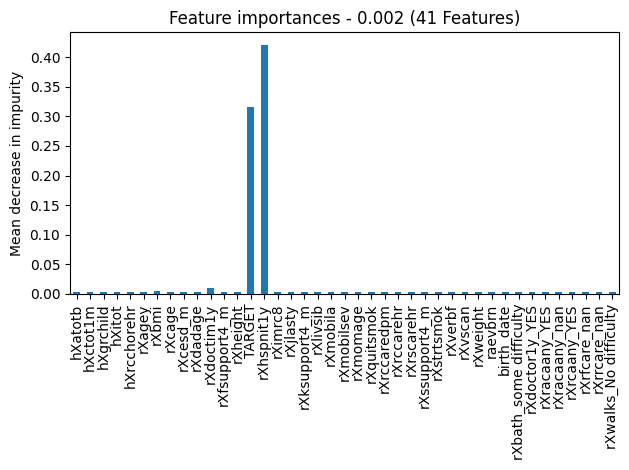

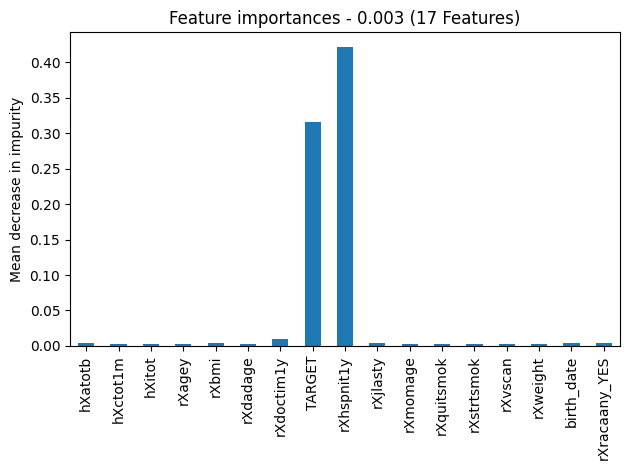

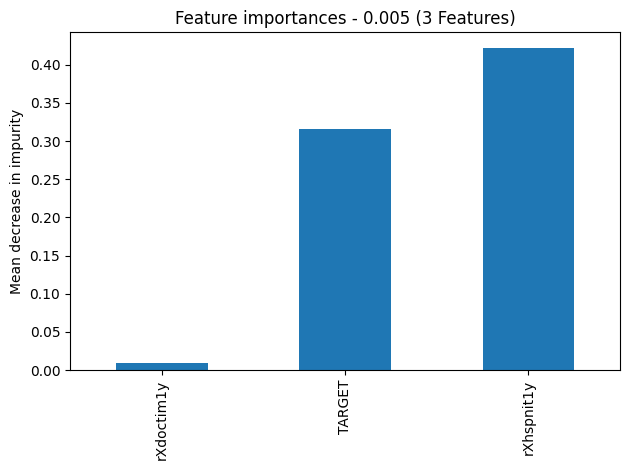

In [127]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


forest_importances = pd.Series(importances, index=X_df.columns)

for margin in [0.002, 0.003, 0.005]:
    forest_importances = forest_importances[forest_importances >= margin]
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title(f"Feature importances - {margin} ({forest_importances.shape[0]} Features)")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()